# Chap03 - Word2Vec

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점

통계 기반 기법에서는 주변 단어의 빈도를 기반으로 단어를 표현했다. 단어의 Co-occurrence Matrix를 만들고, 그 행렬에 SVD를 적용하여 밀집벡터(단어의 분산표현)을 구했다. 하지만 이런 방식은 대규모 말뭉치(corpus)를 다룰 때 문제가 발생한다. 

통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬과 PPMI 등)를 이용해 **단 1회의 처리**(SVD 등)만에 단어의 분산 표현을 얻는다. 하지만 신경망을 이용한 **추론 기법**에서는 미니 배치(학습 데이터의 일부)를 이용해 학습한다.

이처럼 신경망은 미니 배치(mini-batch)로 학습하기 때문에 대규모의 말뭉치에서도 학습시킬 수 있다.

### 3.1.2 추론 기반 기법 개요

추론 기법에서의 추론이란 주변 단어(맥락, context)가 주어졌을 때 "?"에 어떤 단어가 들어가는지 추측하는 것을 말한다.

![](./images/inference.png)

이러한 추론 문제를 방복해서 풀면서 단어의 출현 패턴을 학습한다. 모델은 맥락(context) 정보를 입력받아 각 단어의 출현 확률을 출력한다. '모델 관점'에서 보면 다음과 같다.

![](./images/inference02.png)



### 3.1.3 신경망에서의 단어 처리

신경망의 입력층에서의 뉴런 수를 **고정**하기 위해 단어를 일정 길이를 갖는 **고정 길이 벡터**로 변환 해준다. 이때 사용하는 대표적인 방법이 **원핫** 벡터(one-hot vector)다.

| 단어(텍스트) | 단어 ID | one-hot vector        |
| ------------ | ------- | --------------------- |
| you          | 0       | [1, 0, 0, 0, 0, 0, 0] |
| goodbye      | 2       | [0, 0, 1, 0, 0, 0, 0] |


<img src="./images/one-hot.png" height="65%" width="65%" />

위와 같이 원-핫 벡터로 나타낸 단어 벡터를 신경망의 입력으로 주입하고 완전연결계층(FC layer)를 통해 원-핫 벡터로 표현된 단어를 밀집 벡터로 변환해줄 수 있다.

![](./images/nn.png)

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 입력 (one-hot)
W = np.random.randn(7, 3)  # 가중치 (랜덤한 값), Word vector
h = np.matmul(c, W)  # 은닉층 노드
print(h)

[[ 1.08641249 -0.82780485 -0.29980432]]


위의 코드에서 `c`는 원-핫 표현이며 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터다. 따라서, `c`와 `W`의 행렬곱은 가중치(`W`)의 행벡터 하나를 **뽑아낸** 것과 같다.

![](./images/matmul.png)

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.38687194  0.82963359  0.87623966]]


## 3.2 단순한 Word2Vec

### 3.2.1 CBOW 모델의 추론 처리

**CBOW**(Continuous Bag-Of-Words) 모델은 맥락(context, 주변 단어)로부터 타깃(target, 중심 단어)을 추측하는 신경망이다. 

<img src="./images/cbow.png" height="65%" width="65%" />

- 모델의 입력은 맥락(context) 즉, 주변 단어다.

- 은닉층의 뉴런은 입력층의 완전연결계층에 의해 변환된 값이 되는데, CBOW에서는 `wiindow_size * 2`($C$) 개수 만큼 입력이 되므로 전체의 **평균**(average)을 해준다.  


$$
\mathbf{h} = \frac{1}{C} (h_1 + \cdots h_c)
$$


- 출력층의 뉴런은 해당 단어의 개수(`vocab_size`)와 같고, 뉴런 하나하나가 각 단어에 대응한다. 출력층 뉴런은 각 단어의 **'점수'**(score, softmax를 지나기전 상태)를 뜻하며, 값이 높을 수록 대응 단어의 출현 확률도 높아진다.

- 위의 그림에서 $\mathbf{W}_{\text{in}}$의 각 행(row)과 $\mathbf{W}_{\text{out}}$의 각 열(column)이 바로 단어의 분산 표현이 된다. $\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$ 중 어느것을 써도 상관 없지만 보통 $\mathbf{W}_{\text{in}}$을 사용하는 듯 하다.

<img src="./images/word_vec.png" height="65%" width="65%" />

In [8]:
# CBOW모델의 추론 처리 구현
# chap03/cbow_predict.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)  # average
s = out_layer.forward(h)  # score

print(s)

[[-0.57328213 -0.16244313 -0.67467078  0.64884723  0.02103023 -0.62611472
  -1.48166945]]


### 3.2.2 CBOW 모델의 학습

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정한다. 그 결과 가중치 $\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$에 각 단어의 벡터가 학습된다.

Word2Vec 모델은 단어 출현 패턴을 학습할 때 사용한 말뭉치(corpus)로부터 학습한다. 그렇기 때문에 말뭉치가 다르면 학습 후 얻게 되는 단어의 분산 표현도 달라진다.

<img src="./images/cbow02.png" height="65%" width="65%" />

### 3.2.3 Word2Vec의 가중치와 분산 표현

Word2Vec 모델에서는 $\mathbf{W}_{\text{in}}$의 각 행(row)과 $\mathbf{W}_{\text{out}}$의 각 열(column)이 바로 단어의 분산 표현이 된다. 

최종적으로 이용하는 단어의 분산 표현은 다음과 같이 세 가지 선택 사안이 있다.

- 입력 측의 가중치($\mathbf{W}_{\text{in}}$)만 이용한다.

- 출력 측의 가중치($\mathbf{W}_{\text{out}}$)만 이용한다.

- 양쪽 가중치를 모두 이용한다. ($\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$의 합 등)


Word2Vec에서 특히 skip-gram 모델에서는 '입력 측의 가중치($\mathbf{W}_{\text{in}}$)만 이용한다'가 가장 대중적인 선택이다. 

<img src="./images/word_vec.png" height="65%" width="65%" />

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

Word2Vec, 특히 CBOW에서 이용하는 신경망의 입력은 맥락(context, 주변단어)이고, 정답 레이블은 맥락에 둘러싸인 중앙(center) 단어이다. 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것이다. CBOW 모델에서 입력 데이터인 맥락은 여러 개(`window_size * 2`)가 될 수 있지만 타깃은 오직 하나 뿐이다.

![](./images/train_set.png)

In [1]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [2]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


![](./images/train_set2.png)

In [3]:
# common/util.py
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [4]:
import sys
sys.path.append('..')
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size=1)

In [5]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [6]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

![](./images/one-hot2.png)

In [7]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocabsize), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [1]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [2]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [3]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 모델 구현

In [1]:
# chap03/simple_cbow.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layers.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 학습 코드 구현

In [1]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [2]:
# 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

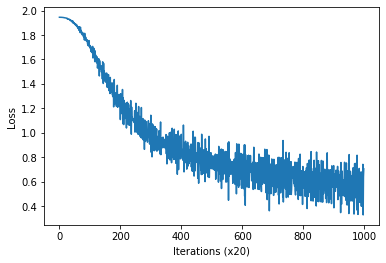

In [3]:
trainer.plot()

In [9]:
# Word Embedding 살펴보기
word_vecs1 = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [-1.3807591 -1.0351917 -1.1238494 -1.0471877  1.0710732]
say [-0.24706812  1.125094    1.1692127   1.155186   -1.1067501 ]
goodbye [-0.56422764 -0.8567286  -0.70119053 -0.8194563   0.9058622 ]
and [-1.9357495   0.7339323   0.7825899   0.7863268  -0.90669537]
i [-0.5696927  -0.82052916 -0.6930974  -0.81896836  0.91717815]
hello [-1.3897839 -1.0456055 -1.1249272 -1.0641869  1.0661185]
. [ 1.6761091  1.2073398  1.221956   1.2177749 -1.0616693]


In [10]:
# Word Embedding 살펴보기
word_vecs2 = model.word_vecs2
for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [ 1.3794202  -0.0171384  -0.13381611 -0.0204448   0.03529608]
say [-0.82926327 -0.7915047  -0.8629559  -0.7897782   0.79196084]
goodbye [-0.72215486  0.6342535   0.58189505  0.60864496 -0.64326966]
and [-0.2469283 -0.7068967 -0.6413974 -0.6825601  0.7388981]
i [-0.73088866  0.5992852   0.5958099   0.6252677  -0.63962674]
hello [ 2.1322184   0.8817386   0.84698176  0.86491984 -0.7129626 ]
. [ 1.3695306  -0.02148964 -0.13318345 -0.03732726  0.01056832]


### t-SNE를 이용한 2차원 공간상의 매핑

In [19]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(word_vecs2)

In [20]:
vocab = list(id_to_word.values())

In [21]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.shape

(7, 2)

In [22]:
df.head()

,x,y
you,-23.973768,1.320695
say,16.637430,-38.964481
goodbye,31.219795,16.350512
and,2.053635,-94.277359
i,57.247684,-79.250206


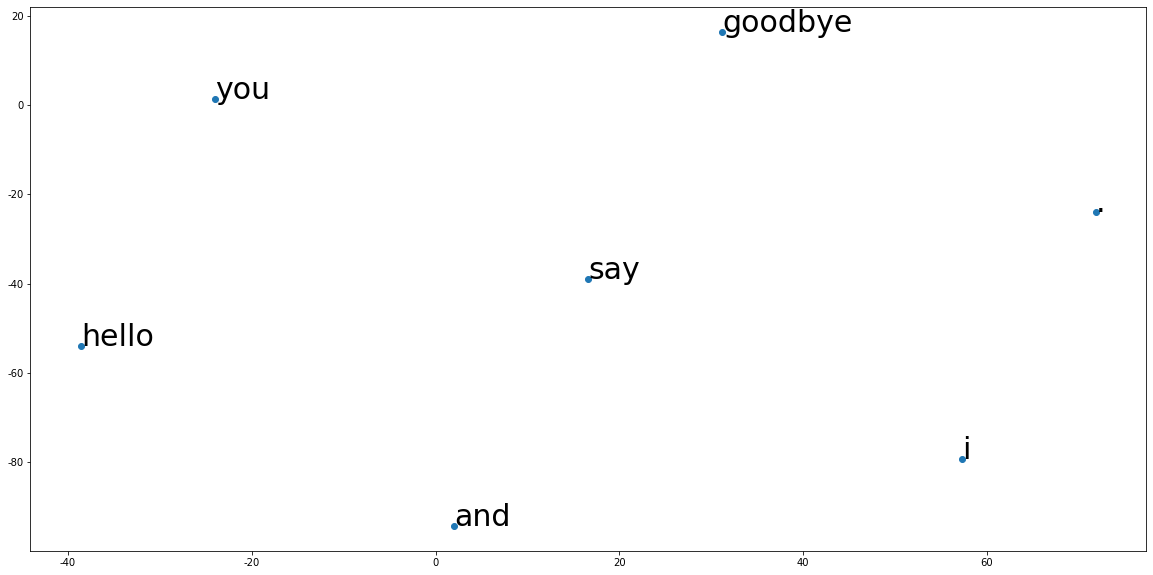

In [23]:
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

## 3.5 Word2Vec 보충

### 3.5.1 CBOW 모델과 확률

- $P(A)$ : A가 발생할 확률


- $P(A|B)$ : **사후확률**, **사건**이 일어난 **후의 확률**을 의미
    - 'B가 주어졌을 때 A가 일어날 확률'
    
    
CBOW 모델은 맥락(contexts)을 주면 타깃 단어가 출현할 확률을 출력하는 것이다. 

![](./images/cbow04.png)

위의 그림처럼, 맥락인 $w_{t-1}$과 $w_{t+1}$이 주어졌을 때 타깃이 $w_t$가 될 확률을 수식으로 나타내면 다음과 같다.


$$
P(w_t | w_{t-1}, w_{t+1})
$$

- $w_{t-1}$과 $w_{t+1}$이 주어졌을 때 $w_t$가 일어날 확률

이 확률을 최대화해야 한다. 하지만 신경망에서의 Cost(Loss) Function는 최소화 문제로 바꿔야하기 때문에, **Negative log likelihood**를 통해 다음과 같이 바꿔준다.

$$
\max{P(w_t | w_{t-1}, w_t+1)} \rightarrow L = -\log{P(w_t | w_{t-1}, w_t+1)}
$$

![](./images/cbow03.png)

### 3.5.2 skip-gram 모델

skip-gram 모델의 입력층은 하나이며, 출력층은 맥락(contexts)의 수만큼 존재한다. 따라서, 각 출력층에서는 개별적으로 손실을 구하고, 이 개별 손실들을 모두 더한 값을 최종 손실로 사용한다.

![](./images/skip-gram02.png)

skip-gram은 다음 식을 모델링한다.


$$
P(w_{t-1}, w_{t+1} | w_t)
$$

skip-gram모델에서는 맥락의 단어들 사이에 관련성이 없다고 가정하는 **'조건부 독립'**에 의해 다음과 같이 분해된다.


$$
P(w_{t-1}, w_{t+1} | w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)
$$

Negative log likelihood를 적용하면 다음과 같이 손실함수를 구할 수 있다.

$$
\begin{align*}
L &= - \log{P(w_{t-1}, w_{t+1} | w_t)} \\ 
&= -\log{P(w_{t-1}, w_{t+1} | w_t)} \\
&= - \left[ \log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t}) \right]
\end{align*}
$$

이를 말중치 전체로 확장하면 skip-gram 모델의 손실함수는 다음과 같다.

$$
L = - \frac{1}{T} \sum_{t=1}^{T}{ \left[ \log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t}) \right]}
$$

![](./images/skip-gram.png)

#### CBOW vs Skip-gram

성능면에서는 skip-gram이 CBOW보다 많이 사용된다. 그 이유는 단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋기 때문이다. 

학습 속도 면에서는 CBOW모델이 더 빠르다. skip-gram모들은 손실을 맥락(contexts)의 수만큼 구해야하므로 그 만큼 계산비용이 커진다.

In [3]:
# chap03/simple_skip_gram.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss
    
    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

### 3.5.3 통계 기반 vs. 추론 기반

- 어휘에 추가할 새단어가 생겨 단어의 분산 표현을 갱신해야 할 경우
    - 통계 기반 기법에서는 계산을 처음부터 다시해야 한다. Co-occurrence Matrix를 다시만들고 SVD를 수행하는 일련의 작업을 다시 해야한다.
    - 추론 기법(word2vec)은 매개변수(가중치)를 다시 학습할 수 있다. 기존에 학습한 가중치를 초기값으로 사용해 다시 학습하면 분산 표현을 효율적으로 갱신할 수 있다.
    
 
- 성능
    - 실제로 단어의 유사성을 정량 평가해본 결과, 의외로 추론 기반과 통계 기반 기법의 우열을 가릴 수 없었다고 한다 → [논문](https://www.aclweb.org/anthology/Q15-1016) 참고